# Clustering de stocks del SP500


El S&P 500 es un índice bursátil que mide el rendimiento de las 500 mayores empresas cotizadas en bolsas de Estados Unidos.

Analizar las empresas del índice con los siguientes objetivos:
 - Agrupar las empresas en función de retorno y volatilidad. 
 - Agrupar las empresas por rendimiento y ratio de dividendos.

### Librerías

In [151]:
import numpy as np 
import pandas as pd
import yfinance as yf
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans 

In [152]:
import pandas_datareader as dr
from pylab import plot,show
import plotly.express as px
from numpy.random import rand
from scipy.cluster.vq import kmeans,vq
from math import sqrt
from sklearn import preprocessing

## 1. Agrupación por retorno y volatilidad

### 1. Carga de los datos

Podemos descargarlos los tickers o identificadores de todos los stocks del S&P 500 de la página de Wikipedia.

In [153]:
# Define the url
sp500_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

# Read in the url and scrape ticker data
data_table = pd.read_html(sp500_url)
sp500_tickers  = data_table[0]['Symbol'].values.tolist()
sp500_tickers  = [s.replace('\n', '') for s in sp500_tickers ]
sp500_tickers  = [s.replace('.', '-') for s in sp500_tickers ]
sp500_tickers  = [s.replace(' ', '') for s in sp500_tickers ]

sp500_tickers [:10]

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']

Y a continuación empleamos el módulo yfinance para descargar datos del último año y guardarlos en un CSV.

In [154]:
# Define the start and end dates for the data you want to download
start_date = '2023-01-01'
end_date = '2023-12-31'

# Create an empty DataFrame to store all the data
sp500_data = pd.DataFrame()

for t, ticker in enumerate(sp500_tickers):
    print(f"Downloading data {t+1}/{len(sp500_tickers)}", end='\r')

    # Download the data
    data = yf.download(ticker, start=start_date, end=end_date, progress=False)

    # Calculate daily returns
    data['Daily Return'] = data['Adj Close'].pct_change()
    
    # Calculate annualized return
    annual_return = (data['Daily Return'].mean() * 252) 
    
    # Calculate annualized volatility
    annual_volatility = (data['Daily Return'].std() * (252 ** 0.5)) 

    # Add a column for the annualized return
    data['Annual Return'] = annual_return
    # Add a column for the annualized volatility
    data['Annual Volatility'] = annual_volatility

    # Add a column for the ticker symbol
    data.insert(0, 'Ticker', ticker)
    # Append the data to the all_data DataFrame
    sp500_data = pd.concat([sp500_data, data])

sp500_data.to_csv('data/sp500_data.csv')

sp500_data.head()

,Ticker,Open,High,Low,Close,Adj Close,Volume,Daily Return,Annual Return,Annual Volatility
Date,,,,,,,,,,
2023-01-03,MMM,121.519997,122.639999,120.370003,122.470001,122.470001,2612800,NaN,-0.077743,0.273922
2023-01-04,MMM,123.349998,125.290001,122.709999,125.150002,125.150002,2769700,0.021883,-0.077743,0.273922
2023-01-05,MMM,124.209999,124.570000,122.459999,122.959999,122.959999,2606600,-0.017499,-0.077743,0.273922
2023-01-06,MMM,124.660004,127.129997,123.750000,126.720001,126.720001,2417000,0.030579,-0.077743,0.273922
2023-01-09,MMM,127.000000,129.460007,126.110001,126.790001,126.790001,2871300,0.000552,-0.077743,0.273922


Para la agrupación que buscamos, de entre todos los datos, nos vamos a quedar con el último precio de cierre ajustado (Adj. Price) para cada stock.

In [67]:
sp500_data = pd.read_csv('data/sp500_data.csv', index_col=[0])
sp500_data

,Ticker,Open,High,Low,Close,Adj Close,Volume,Daily Return,Annual Return,Annual Volatility
Date,,,,,,,,,,
2023-01-03,MMM,121.519997,122.639999,120.370003,122.470001,113.601265,2612800,NaN,-0.018755,0.272455
2023-01-04,MMM,123.349998,125.290001,122.709999,125.150002,116.087181,2769700,0.021883,-0.018755,0.272455
2023-01-05,MMM,124.209999,124.570000,122.459999,122.959999,114.055763,2606600,-0.017499,-0.018755,0.272455
2023-01-06,MMM,124.660004,127.129997,123.750000,126.720001,117.543495,2417000,0.030579,-0.018755,0.272455
2023-01-09,MMM,127.000000,129.460007,126.110001,126.790001,117.608421,2871300,0.000552,-0.018755,0.272455
...,...,...,...,...,...,...,...,...,...,...
2023-12-22,ZTS,195.320007,195.910004,192.740005,194.979996,194.538773,1548400,0.001644,0.339549,0.250276
2023-12-26,ZTS,194.880005,196.339996,194.089996,195.500000,195.057587,814600,0.002667,0.339549,0.250276
2023-12-27,ZTS,195.410004,197.009995,194.740005,196.899994,196.454422,766400,0.007161,0.339549,0.250276


In [155]:
sp500_data_clean = pd.DataFrame(columns=sp500_data.columns)

for t, ticker in enumerate(sp500_tickers):
    latest_row = sp500_data[sp500_data['Ticker'] == ticker].tail(1)
    sp500_data_clean = pd.concat([sp500_data_clean, latest_row], axis=0)

sp500_data_clean


C:\Users\icira\AppData\Local\Temp\ipykernel_11780\3892866866.py:5: FutureWarning:

The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.

C:\Users\icira\AppData\Local\Temp\ipykernel_11780\3892866866.py:5: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



,Ticker,Open,High,Low,Close,Adj Close,Volume,Daily Return,Annual Return,Annual Volatility
2023-12-29,MMM,109.500000,109.959999,108.750000,109.320000,109.320000,2414000,-0.003373,-0.077743,0.273922
2023-12-29,AOS,82.029999,82.769997,82.029999,82.440002,82.116905,610900,0.002432,0.396546,0.278836
2023-12-29,ABT,110.400002,110.730003,109.830002,110.070000,109.540817,3550200,-0.002989,0.044084,0.198653
2023-12-29,ABBV,154.539993,155.210007,154.410004,154.970001,153.503372,3711400,0.001422,0.012145,0.196153
2023-12-29,ACN,351.790009,352.910004,349.429993,350.910004,349.633270,1233500,-0.001934,0.304053,0.218359
...,...,...,...,...,...,...,...,...,...,...
2023-12-29,YUM,130.410004,131.250000,130.210007,130.660004,130.009369,1196800,0.001073,0.060950,0.161497
2023-12-29,ZBRA,274.730011,276.309998,272.769989,273.329987,273.329987,251300,-0.007336,0.136283,0.411914
2023-12-29,ZBH,121.459999,122.400002,121.239998,121.699997,121.699997,849600,0.000576,-0.016425,0.205559
2023-12-29,ZION,44.650002,44.650002,43.720001,43.869999,43.412785,1420600,-0.017689,0.160985,0.644510


### 2. Determinar el número óptimo de clústers

Vamos a emplear el método del "codo" para intuir el número óptimo de clústers.

Primero preparamos los datos, emplearemos solo las columnas de retorno y volatilidad.

In [156]:
data = np.asarray([np.asarray(sp500_data_clean['Annual Return']),np.asarray(sp500_data_clean['Annual Volatility'])]).T
data

array([[-0.07774295,  0.2739216 ],
       [ 0.39654583,  0.27883621],
       [ 0.04408441,  0.19865295],
       ...,
       [-0.01642495,  0.20555914],
       [ 0.16098486,  0.64450954],
       [ 0.33954941,  0.25027623]])

Podemos visualizar los datos para intuir el número óptimo de clústers.

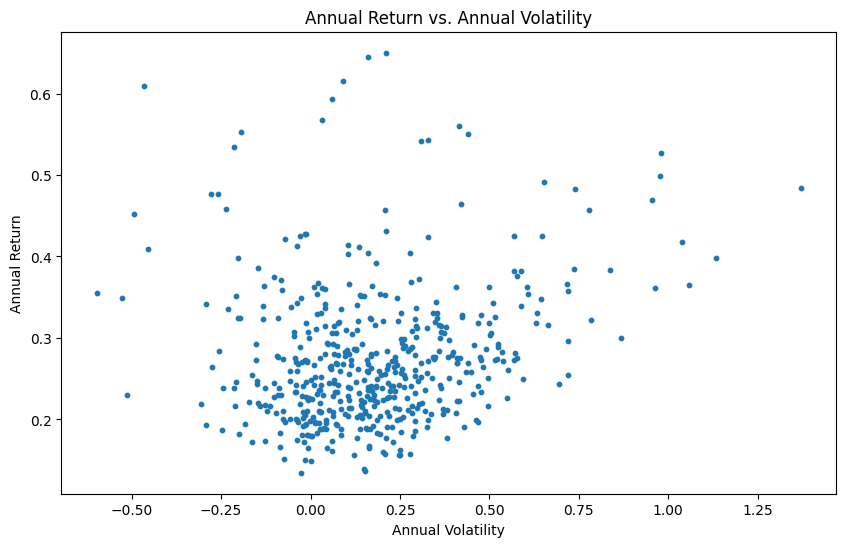

In [157]:
data_fig = plt.figure(figsize=(10, 6))
plt.scatter(data[:,0], data[:,1], s=10)
plt.title('Annual Return vs. Annual Volatility')
plt.xlabel('Annual Volatility')
plt.ylabel('Annual Return')
plt.show()

Ejecutamos el algoritmo KMeans para un número de clústers entre 2 y 20 y guardamos el valor de la inercia en una lista.

La inercia es la suma de las distancias al cuadrado de cada punto a su centroide más cercano. Cuanto menor sea la inercia, mejor será el clúster.

Text(0.5, 1.0, 'Elbow curve')

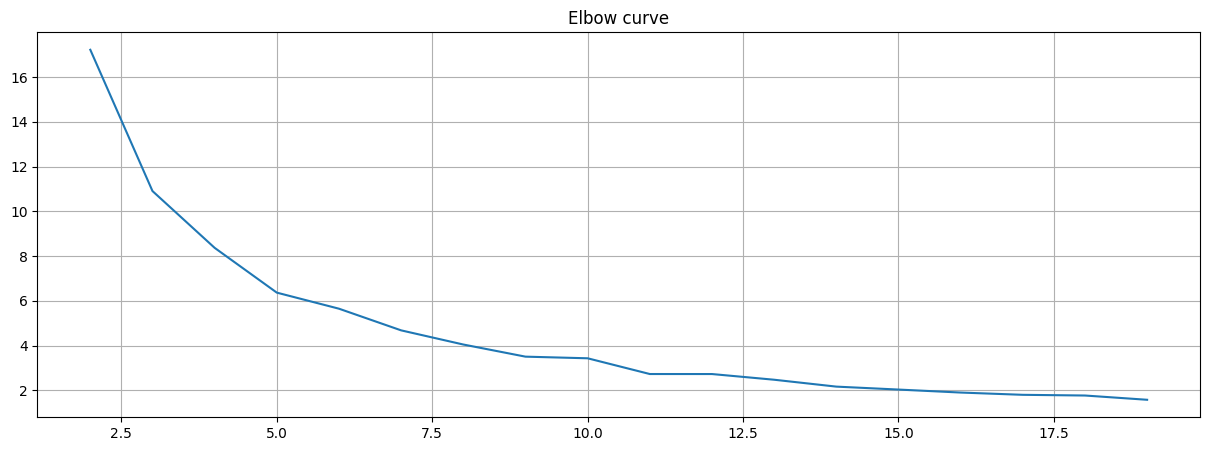

In [159]:
distortions = []
for i in range(2, 20):
    kmeans = KMeans(n_clusters=i, n_init='auto')
    kmeans.fit(data)
    distortions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distortions)
plt.grid(True)
plt.title('Elbow curve')

### 3. Aplicar KMeans

Ejecutamos completamente el algoritmo para el que consideremos número óptimo de clústers.

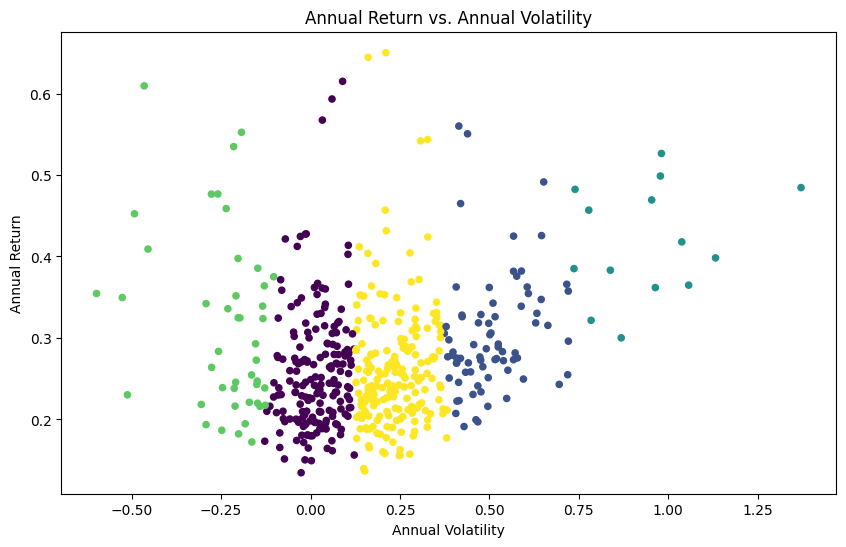

In [161]:
kmeans = KMeans(n_clusters = 5, n_init='auto', verbose=0)

# Computing K-Means with K = 3 (5 clusters)
kmeans.fit(data)

# The centers of the clusters
centers = kmeans.cluster_centers_
centers_x = centers[:, 0]
centers_y = centers[:, 1]

# The labels of the clusters
labels = kmeans.labels_

# Add the labels to the data
sp500_data_clean['Cluster'] = labels

fig = plt.figure(figsize=(10, 6))
plt.scatter(data[:, 0], data[:, 1], c=labels, s=20, cmap='viridis')
plt.title('Annual Return vs. Annual Volatility')
plt.xlabel('Annual Volatility')
plt.ylabel('Annual Return')
plt.show()

### 4. KMeans "a mano"

In [162]:
import numpy as np

def initialize_centroids(points, k):
    """Randomly initialize k centroids from the dataset."""
    centroids = points.copy()
    np.random.shuffle(centroids)
    return centroids[:k]

def closest_centroid(points, centroids):
    """Assign each point to the closest centroid."""
    distances = np.sqrt(((points - centroids[:, np.newaxis])**2).sum(axis=2))
    return np.argmin(distances, axis=0)

def move_centroids(points, closest, centroids):
    """Reposition each centroid to the mean of the points assigned to it."""
    return np.array([points[closest==k].mean(axis=0) for k in range(centroids.shape[0])])

def kmeans(points, k, max_iters=100):
    """K-means algorithm implementation."""
    centroids = initialize_centroids(points, k)
    for _ in range(max_iters):
        closest = closest_centroid(points, centroids)
        new_centroids = move_centroids(points, closest, centroids)
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    return centroids, closest

In [164]:
def plot_kmeans(points, centroids, closest, k):
    """Plot the results of K-means clustering with different colors per cluster."""
    colors = ['r', 'g', 'b', 'y', 'c', 'm']  # Extend this list for more clusters
    for i in range(k):
        # Plot points assigned to cluster i
        plt.scatter(points[closest == i, 0], points[closest == i, 1], s=20, c=colors[i], label=f'Cluster {i}')
        # Plot centroid i
        plt.scatter(centroids[i, 0], centroids[i, 1], s=100, c=colors[i], marker='X', edgecolor='k', label=f'Centroid {i}')
    plt.title('K-means Clustering Results')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.show()

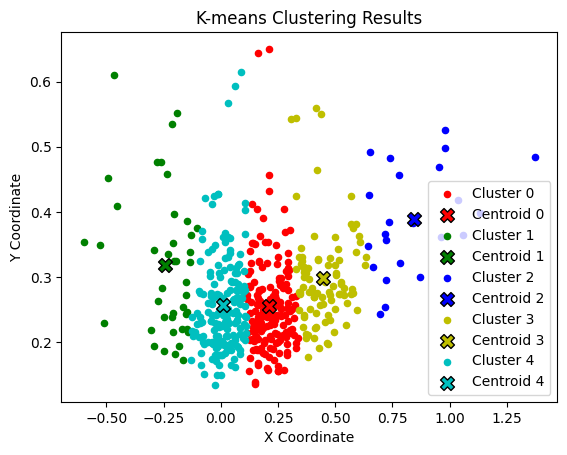

In [165]:
centroids, closest = kmeans(data, 5)
plot_kmeans(data, centroids, closest, 5)

### 5. Tratamiento de outliers

Observando el gráfico tenemos distribución de puntos muy concentrada con algunos puntos que pudieran ser considerados outliers, esto es, puntos significativamente diferentes de lso demás. 

Esto uede llevar a resolutados improcedentes en el algoritmo KMeans.

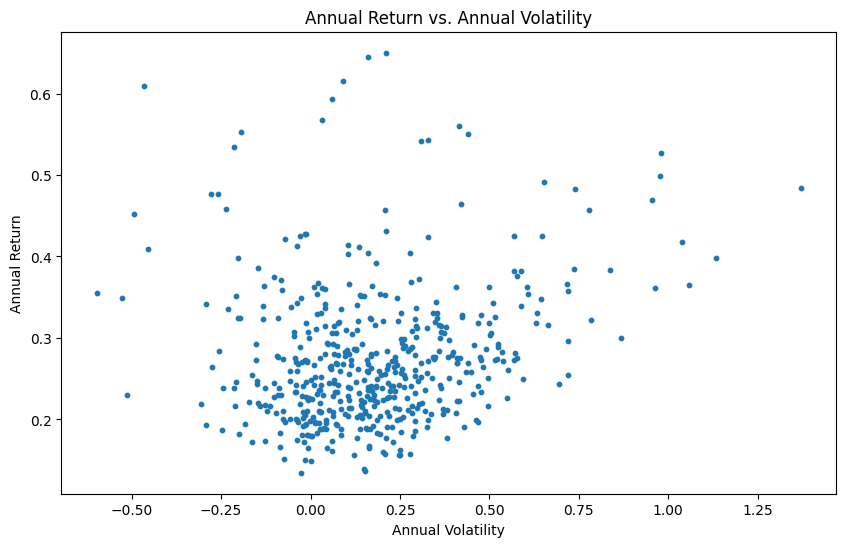

In [166]:
data_fig = plt.figure(figsize=(10, 6))
plt.scatter(data[:,0], data[:,1], s=10)
plt.title('Annual Return vs. Annual Volatility')
plt.xlabel('Annual Volatility')
plt.ylabel('Annual Return')
plt.show()

In [168]:
# Automatic outlier detection
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Train the model
model = IsolationForest(contamination=0.1)
model.fit(data_scaled)

# Add the anomaly scores to the data
sp500_data_clean['Anomaly Score'] = model.decision_function(data_scaled)

# Add the anomaly labels to the data
sp500_data_clean['Anomaly'] = model.predict(data_scaled)

# Display the data
sp500_data_clean

,Ticker,Open,High,Low,Close,Adj Close,Volume,Daily Return,Annual Return,Annual Volatility,Cluster,Anomaly Score,Anomaly
2023-12-29,MMM,109.500000,109.959999,108.750000,109.320000,109.320000,2414000,-0.003373,-0.077743,0.273922,0,0.115917,1
2023-12-29,AOS,82.029999,82.769997,82.029999,82.440002,82.116905,610900,0.002432,0.396546,0.278836,1,0.125860,1
2023-12-29,ABT,110.400002,110.730003,109.830002,110.070000,109.540817,3550200,-0.002989,0.044084,0.198653,0,0.151140,1
2023-12-29,ABBV,154.539993,155.210007,154.410004,154.970001,153.503372,3711400,0.001422,0.012145,0.196153,0,0.149021,1
2023-12-29,ACN,351.790009,352.910004,349.429993,350.910004,349.633270,1233500,-0.001934,0.304053,0.218359,4,0.133814,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-29,YUM,130.410004,131.250000,130.210007,130.660004,130.009369,1196800,0.001073,0.060950,0.161497,0,0.068383,1
2023-12-29,ZBRA,274.730011,276.309998,272.769989,273.329987,273.329987,251300,-0.007336,0.136283,0.411914,4,0.044313,1
2023-12-29,ZBH,121.459999,122.400002,121.239998,121.699997,121.699997,849600,0.000576,-0.016425,0.205559,0,0.153636,1
2023-12-29,ZION,44.650002,44.650002,43.720001,43.869999,43.412785,1420600,-0.017689,0.160985,0.644510,4,-0.147022,-1


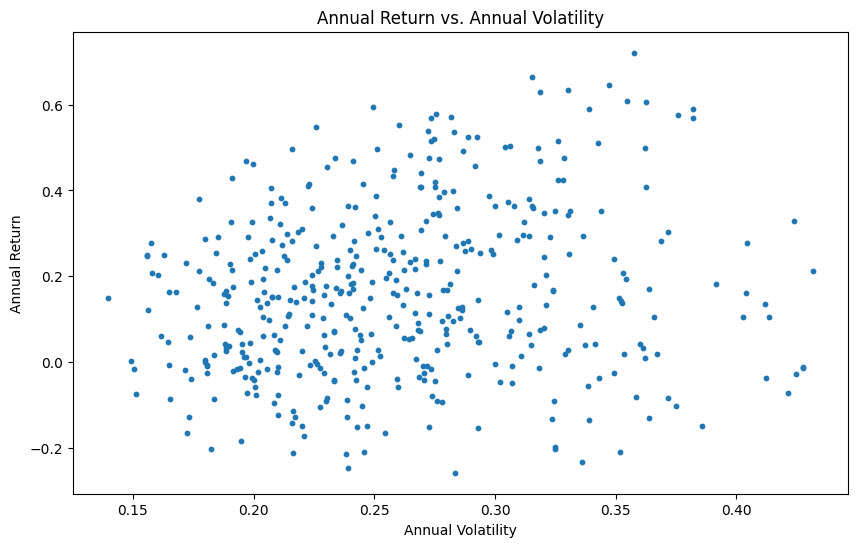

In [169]:
# remove outliers
data_no_outliers = sp500_data_clean[sp500_data_clean['Anomaly'] != -1]

# Plot the data without outliers
data_fig = plt.figure(figsize=(10, 6))
plt.scatter(data_no_outliers['Annual Volatility'], data_no_outliers['Annual Return'], s=10)
plt.title('Annual Return vs. Annual Volatility')
plt.xlabel('Annual Volatility')
plt.ylabel('Annual Return')
plt.show()

[[ 0.20197599  0.23764455]
 [-0.08667035  0.2446847 ]
 [ 0.53469276  0.29413623]
 [ 0.34723122  0.27450695]
 [ 0.05809688  0.26996765]] [ 0.20197599 -0.08667035  0.53469276  0.34723122  0.05809688] [0.23764455 0.2446847  0.29413623 0.27450695 0.26996765]


C:\Users\icira\AppData\Local\Temp\ipykernel_11780\4220231187.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



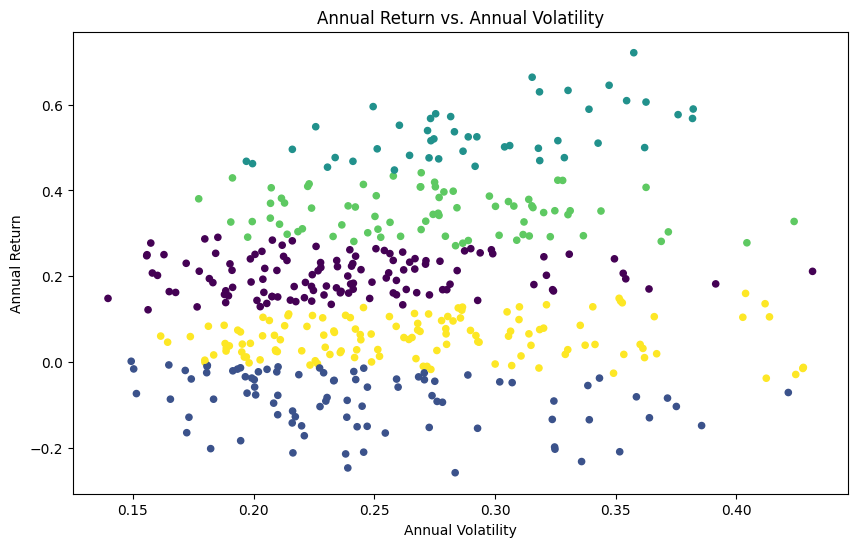

In [170]:
# K-means clustering
kmeans = KMeans(n_clusters = 5, n_init='auto', verbose=0)

# Computing K-Means with K = 3 (5 clusters)
kmeans.fit(data_no_outliers[['Annual Return', 'Annual Volatility']])
# The centers of the clusters
centers = kmeans.cluster_centers_
centers_x = centers[:, 0]
centers_y = centers[:, 1]
print(centers, centers_x, centers_y)

# The labels of the clusters
labels = kmeans.labels_

# Add the labels to the data
data_no_outliers['Cluster'] = labels

# Plot the data
fig = plt.figure(figsize=(10, 6))
plt.scatter(data_no_outliers['Annual Volatility'], data_no_outliers['Annual Return'], c=labels, s=20, cmap='viridis')
plt.title('Annual Return vs. Annual Volatility')
plt.xlabel('Annual Volatility')
plt.ylabel('Annual Return')
plt.show()


## 2. Agrupación por rendimiento y ratio de dividendos

Repetimos el mismo proedimiento para agrupar las empresas por rendimiento y ratio de dividendos de cada empresa.

### 1. Carga de los datos

In [171]:
# Download trailingPE and dividendRate 
trailingPE_list = []
dividendRate_list = []

for it, t in enumerate(sp500_tickers):
    print(f"Downloading data {it}/{len(sp500_tickers)}", end='\r')
   
    tick = yf.Ticker(t)
    ticker_info = tick.info

    try:
        trailingPE = ticker_info['trailingPegRatio']
        trailingPE_list.append(trailingPE)
    except Exception as e:
        #print("Error1:", e)
        trailingPE_list.append('na')

    try:
        dividendRate = ticker_info['dividendRate']
        dividendRate_list.append(dividendRate)
    except Exception as e:
        #print("Error2:", e)
        dividendRate_list.append('na')


In [172]:
# Create a datafrane to contain the data
sp_features_df = pd.DataFrame()

# Add the ticker, trailingPE and dividendRate data
sp_features_df['Ticker'] = sp500_tickers
sp_features_df['trailingPegRatio'] = trailingPE_list
sp_features_df['dividendRate'] = dividendRate_list

# Shares with 'na' as dividend rate has no dividend so we have to assign 0 as dividend rate in this cases
sp_features_df["dividendRate"] = sp_features_df["dividendRate"].fillna(0)

# filter shares with 'na' as trailingPE 
df_mask = sp_features_df['trailingPegRatio'] != 'na' 
sp_features_df = sp_features_df[df_mask]

# Convert trailingPE numbers to float type
sp_features_df['trailingPegRatio'] = sp_features_df['trailingPegRatio'].astype(float)

# Removes the rows that contains NULL values 
sp_features_df=sp_features_df.dropna()

### 2. Determinar el número óptimo de clústers

Text(0.5, 1.0, 'Elbow curve')

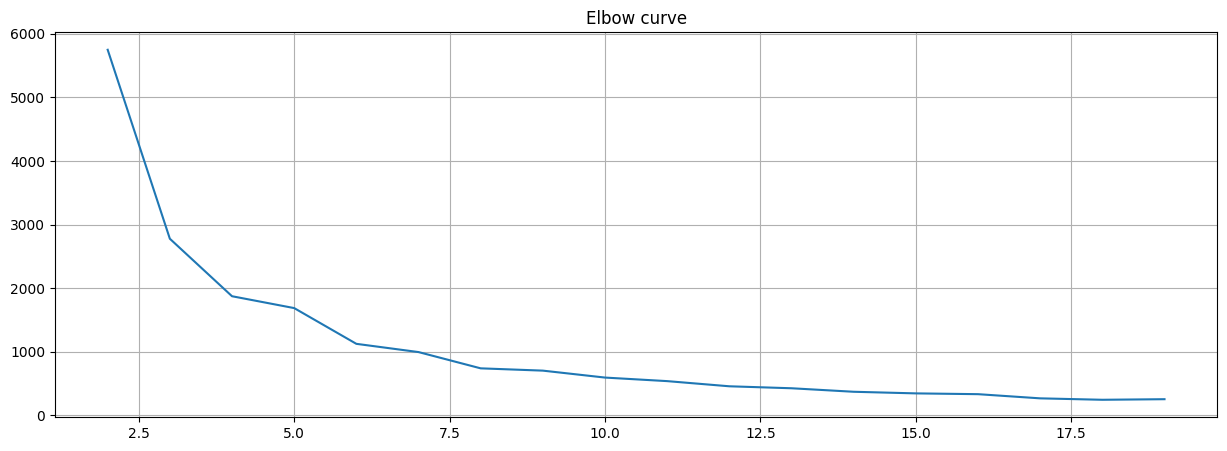

In [173]:
# Drop na
sp_features_df = sp_features_df.dropna()

# drop rows with value na in trailingPegRatio or dividendRate
sp_features_df = sp_features_df[sp_features_df['trailingPegRatio'] != 'na']
sp_features_df = sp_features_df[sp_features_df['dividendRate'] != 'na']

# Format the data as a numpy array to feed into the K-Means algorithm
data = np.asarray([np.asarray(sp_features_df['trailingPegRatio']),np.asarray(sp_features_df['dividendRate'])]).T
X = data
distorsions = []
for k in range(2, 20):
    k_means = KMeans(n_clusters=k, n_init='auto', verbose=False)
    k_means.fit(X)
    distorsions.append(k_means.inertia_)
fig = plt.figure(figsize=(15, 5))

plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')

### 3. Aplicar KMeans

    Ticker  trailingPegRatio dividendRate  Cluster
0      MMM            2.0430         6.04      0.0
1      AOS            2.0467         1.28      2.0
2      ABT           28.9976          2.2      1.0
3     ABBV            1.6581          6.2      0.0
4      ACN            2.5506         5.16      0.0
..     ...               ...          ...      ...
497    XYL            2.2367         1.44      NaN
498    YUM            2.3105         2.68      NaN
500    ZBH            2.4037         0.96      NaN
501   ZION           10.0501         1.64      NaN
502    ZTS            3.8975         1.73      NaN

[315 rows x 4 columns]


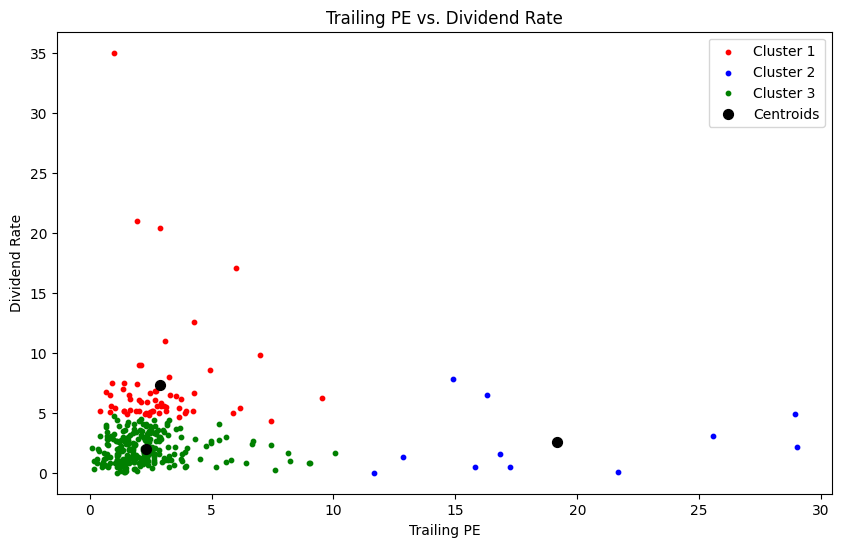

In [174]:
k_means = KMeans(n_clusters = 3, n_init='auto', verbose=0)
k_means.fit(X)

# Computing K-Means with K = 3 (3 clusters)
centroids = k_means.cluster_centers_

# Assign each sample to a cluster
idx = k_means.fit_predict(X)

# Create the clusters from the numpy array 'data'
cluster_1 = data[idx==0,0],data[idx==0,1]
cluster_2 = data[idx==1,0],data[idx==1,1]
cluster_3 = data[idx==2,0],data[idx==2,1]

# Create a dataframe with the tickers and the clusters that's belong to
details = [(name,cluster) for name, cluster in zip(sp_features_df.index,idx)]
details_df = pd.DataFrame(details)

# Rename columns
details_df.columns = ['Ticker','Cluster']

# Create another dataframe with the tickers and data from each stock
clusters_df = sp_features_df

# Bring the clusters information from the dataframe 'details_df'
clusters_df['Cluster'] = details_df['Cluster']

print(clusters_df)

# Rename columns
clusters_df.columns = ['Ticker', 'trailingPegRatio', 'dividendRate', 'Cluster']

# Plot the clusters created using Plotly
fig = plt.figure(figsize=(10, 6))
plt.scatter(data[idx==0,0],data[idx==0,1], s=10, c='red', label='Cluster 1')
plt.scatter(data[idx==1,0],data[idx==1,1], s=10, c='blue', label='Cluster 2')
plt.scatter(data[idx==2,0],data[idx==2,1], s=10, c='green', label='Cluster 3')
plt.scatter(centroids[:,0],centroids[:,1], s=50, c='black', label='Centroids')
plt.title('Trailing PE vs. Dividend Rate')
plt.xlabel('Trailing PE')
plt.ylabel('Dividend Rate')
plt.legend()    
plt.show()

### 4. Eliminación de Outliers

Estos datos en particular contienen mucha dispersión en ambos ejes, podemos tomar los datos extremos como outliers y eliminarlos.

In [175]:
# Automatic outlier detection
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Train the model
model = IsolationForest(contamination=0.1)
model.fit(data_scaled)

# Add the anomaly scores to the data
sp_features_df['Anomaly Score'] = model.decision_function(data_scaled)

# Add the anomaly labels to the data
sp_features_df['Anomaly'] = model.predict(data_scaled)

# Display the data
sp_features_df


,Ticker,trailingPegRatio,dividendRate,Cluster,Anomaly Score,Anomaly
0,MMM,2.0430,6.04,0.0,0.095784,1
1,AOS,2.0467,1.28,2.0,0.137202,1
2,ABT,28.9976,2.2,1.0,-0.234905,-1
3,ABBV,1.6581,6.2,0.0,0.086314,1
4,ACN,2.5506,5.16,0.0,0.107755,1
...,...,...,...,...,...,...
497,XYL,2.2367,1.44,NaN,0.139222,1
498,YUM,2.3105,2.68,NaN,0.136268,1
500,ZBH,2.4037,0.96,NaN,0.133538,1
501,ZION,10.0501,1.64,NaN,-0.054829,-1


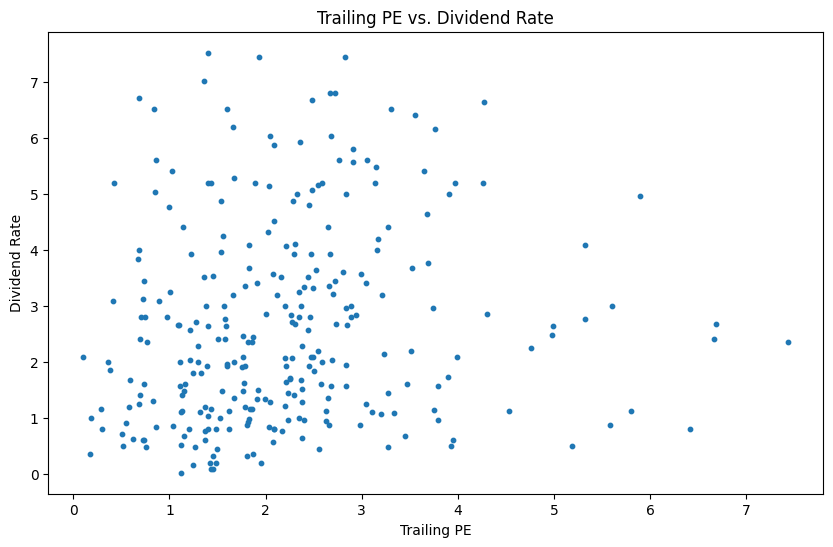

In [176]:
# remove outliers
data_no_outliers = sp_features_df[sp_features_df['Anomaly'] != -1]

# Plot the data without outliers
fig = plt.figure(figsize=(10, 6))
plt.scatter(data_no_outliers['trailingPegRatio'], data_no_outliers['dividendRate'], s=10)
plt.title('Trailing PE vs. Dividend Rate')
plt.xlabel('Trailing PE')
plt.ylabel('Dividend Rate')
plt.show()


[[3.55319155 2.30549296]
 [1.47947591 1.47372263]
 [2.23772533 5.09146667]] [3.55319155 1.47947591 2.23772533] [2.30549296 1.47372263 5.09146667]


C:\Users\icira\AppData\Local\Temp\ipykernel_11780\2585846654.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



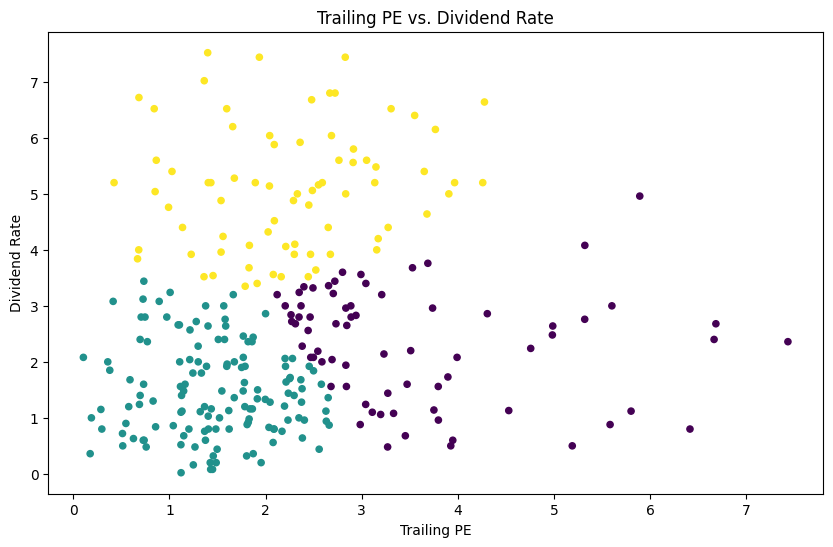

In [177]:
# K-means clustering
kmeans = KMeans(n_clusters = 3, n_init='auto', verbose=0)

# Computing K-Means with K = 3 (3 clusters)
kmeans.fit(data_no_outliers[['trailingPegRatio', 'dividendRate']])
# The centers of the clusters
centers = kmeans.cluster_centers_
centers_x = centers[:, 0]
centers_y = centers[:, 1]
print(centers, centers_x, centers_y)

# The labels of the clusters
labels = kmeans.labels_

# Add the labels to the data
data_no_outliers['Cluster'] = labels

# Plot the data
fig = plt.figure(figsize=(10, 6))
plt.scatter(data_no_outliers['trailingPegRatio'], data_no_outliers['dividendRate'], c=labels, s=20, cmap='viridis')
plt.title('Trailing PE vs. Dividend Rate')
plt.xlabel('Trailing PE')
plt.ylabel('Dividend Rate')
plt.show()
